In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import geopandas as gpd
import numpy as np
import os
import scipy as sc
import requests
import datetime
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pal = sns.cubehelix_palette(8, rot=-.222, dark=.1)

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [65]:
file_final = pd.read_csv('../traffic/file_final.csv', parse_dates=['DATETIME'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M'))

In [66]:
file_final=file_final.drop(['Unnamed: 0','index', 'prev15', 'prev30'], axis=1)
file_final.head()

,ID_SENSOR,DIRECTION,DATETIME,NUM_VEHICLES,SPEED_MEAN,SPEED_SD,EVENT,LON,LAT,Temp,Humidity,Wind,Pressure
0,1,0,2018-09-01 08:00:00,504.0,99.3,17.19,NO_EVENT,12.291754,41.800588,24.69,0.69,5.04,1014.98
1,1,0,2018-09-01 08:15:00,481.0,102.1,18.12,NO_EVENT,12.291754,41.800588,24.78,0.69,5.02,1015.01
2,1,0,2018-09-01 08:30:00,617.0,99.2,17.91,NO_EVENT,12.291754,41.800588,24.86,0.69,5.07,1015.03
3,1,0,2018-09-01 08:45:00,562.0,101.7,16.62,NO_EVENT,12.291754,41.800588,24.95,0.69,5.18,1015.06
4,1,0,2018-09-01 09:00:00,521.0,99.7,17.06,NO_EVENT,12.291754,41.800588,25.03,0.69,5.35,1015.09


In [67]:
a = file_final.set_index('DATETIME')
a1 = a.resample('H').mean()
a1=a1.dropna(subset=['NUM_VEHICLES', 'SPEED_MEAN', 'SPEED_SD'], axis=0, thresh=2)
a1.head()

,ID_SENSOR,DIRECTION,NUM_VEHICLES,SPEED_MEAN,SPEED_SD,LON,LAT,Temp,Humidity,Wind,Pressure
DATETIME,,,,,,,,,,,
2018-09-01 02:00:00,3.333333,0.333333,74.583333,88.650000,21.152500,13.52311,40.664995,21.303333,0.923333,2.442500,1014.535000
2018-09-01 03:00:00,3.333333,0.333333,78.250000,90.041667,20.769167,13.52311,40.664995,21.161667,0.885000,2.234167,1014.421667
2018-09-01 04:00:00,3.333333,0.333333,116.166667,92.283333,20.708333,13.52311,40.664995,20.951667,0.813333,2.435833,1014.407500
2018-09-01 05:00:00,3.333333,0.333333,212.333333,91.050000,19.603333,13.52311,40.664995,21.373333,0.850000,2.756667,1014.492500
2018-09-01 06:00:00,3.333333,0.333333,383.750000,91.258333,18.941667,13.52311,40.664995,22.632500,0.815000,3.175000,1014.651667


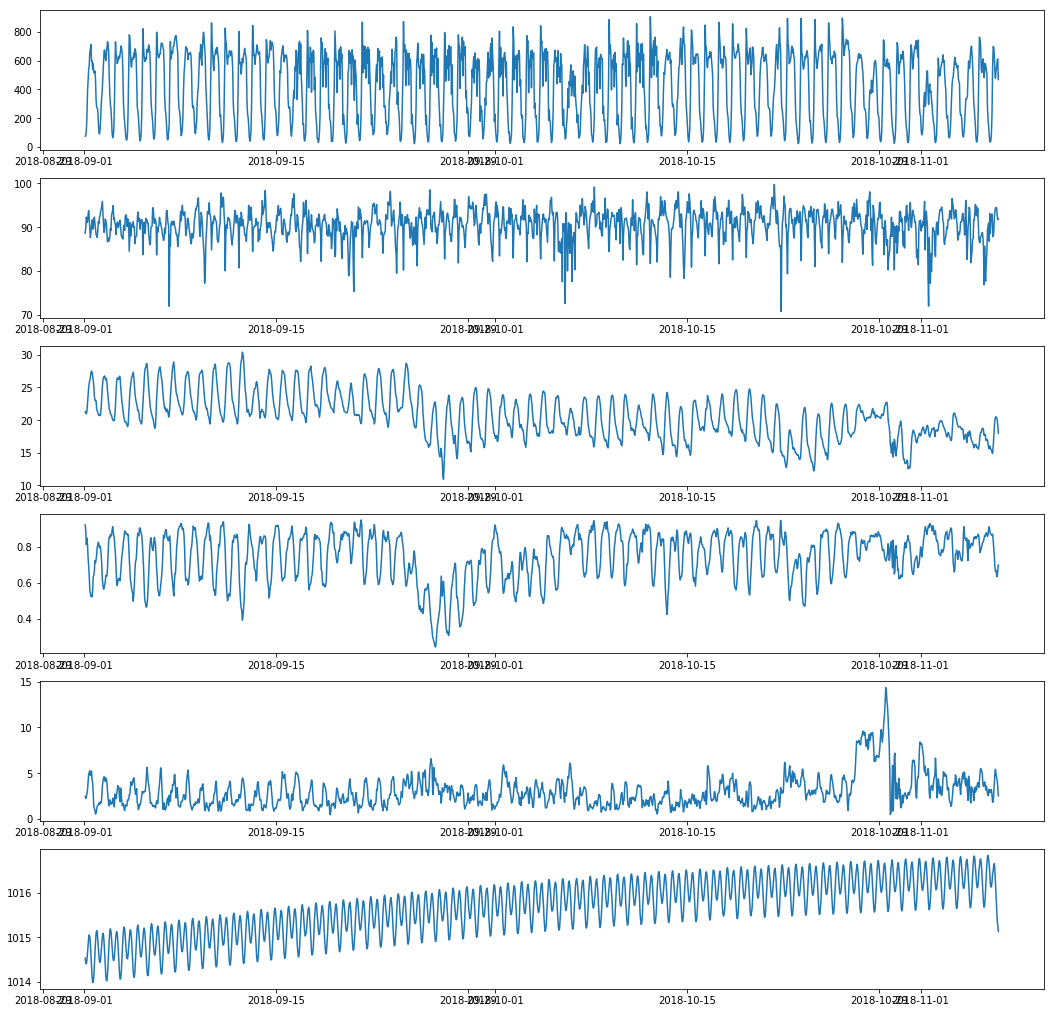

In [69]:
#Plotting hourly data to see whether there is a correlation


plt.figure(figsize=(2^16, 2^16))

plt.subplot(6, 1, 1)
plt.plot(a1.index, a1.NUM_VEHICLES)


plt.subplot(6, 1, 2)
plt.plot(a1.index, a1.SPEED_MEAN)

plt.subplot(6, 1, 3)
plt.plot(a1.index, a1.Temp)

plt.subplot(6, 1, 4)
plt.plot(a1.index, a1.Humidity)

plt.subplot(6, 1, 5)
plt.plot(a1.index, a1.Wind)

plt.subplot(6, 1, 6)
plt.plot(a1.index, a1.Pressure)

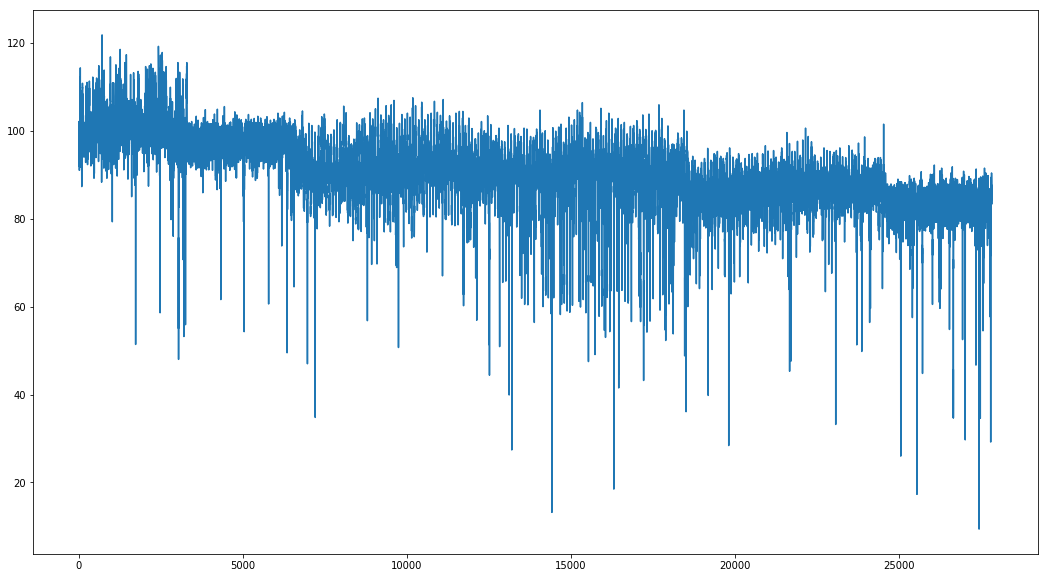

In [70]:
figure = plt.figure(figsize=(2^16, 2^8))
plt.plot(file_final.SPEED_MEAN)
plt.show()

In [77]:
adfuller(file_final.SPEED_MEAN)  # the data does not seem to be following the random walk (quarter of hour data)

(-9.962797616260367,
 2.3492823537050586e-17,
 50,
 27789,
 {'1%': -3.4305853414716188,
  '5%': -2.861644014265152,
  '10%': -2.5668253636720704},
 153127.0372953031)

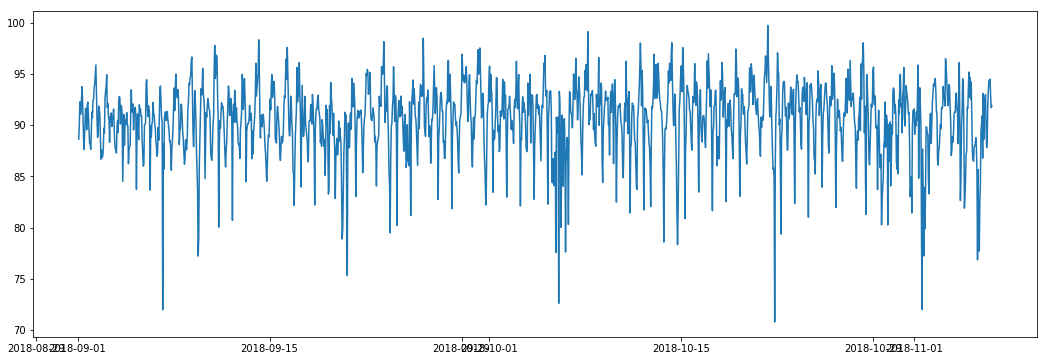

In [71]:
figure = plt.figure(figsize=(2^16, 2^4))
plt.plot(a1.SPEED_MEAN)

In [72]:
adfuller(a1.SPEED_MEAN)  # the data seems to be following the random walk (hourly)

(-5.479669946828065,
 2.2993882368938748e-06,
 24,
 1573,
 {'1%': -3.4345140199818918,
  '5%': -2.8633791658322503,
  '10%': -2.567749139071643},
 7394.389208100021)

So it makes sense to explore the hourly data.

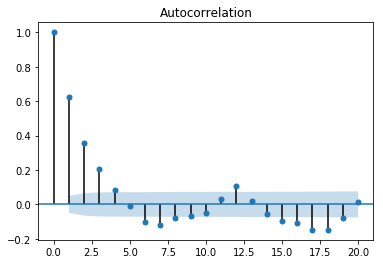

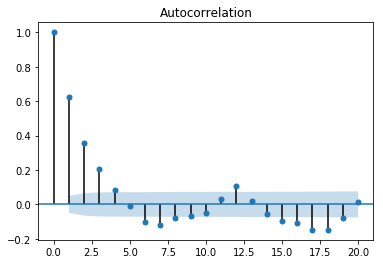

In [73]:
plt.subplot(2,1,2)
plot_acf(a1.SPEED_MEAN, lags=20)

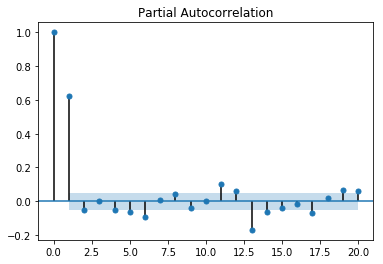

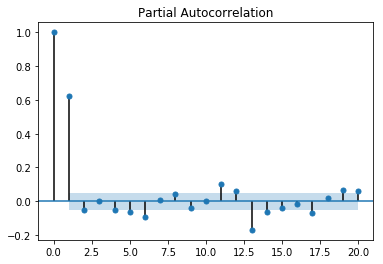

In [74]:
plot_pacf(a1.SPEED_MEAN, lags=20)

0.27166903105557655

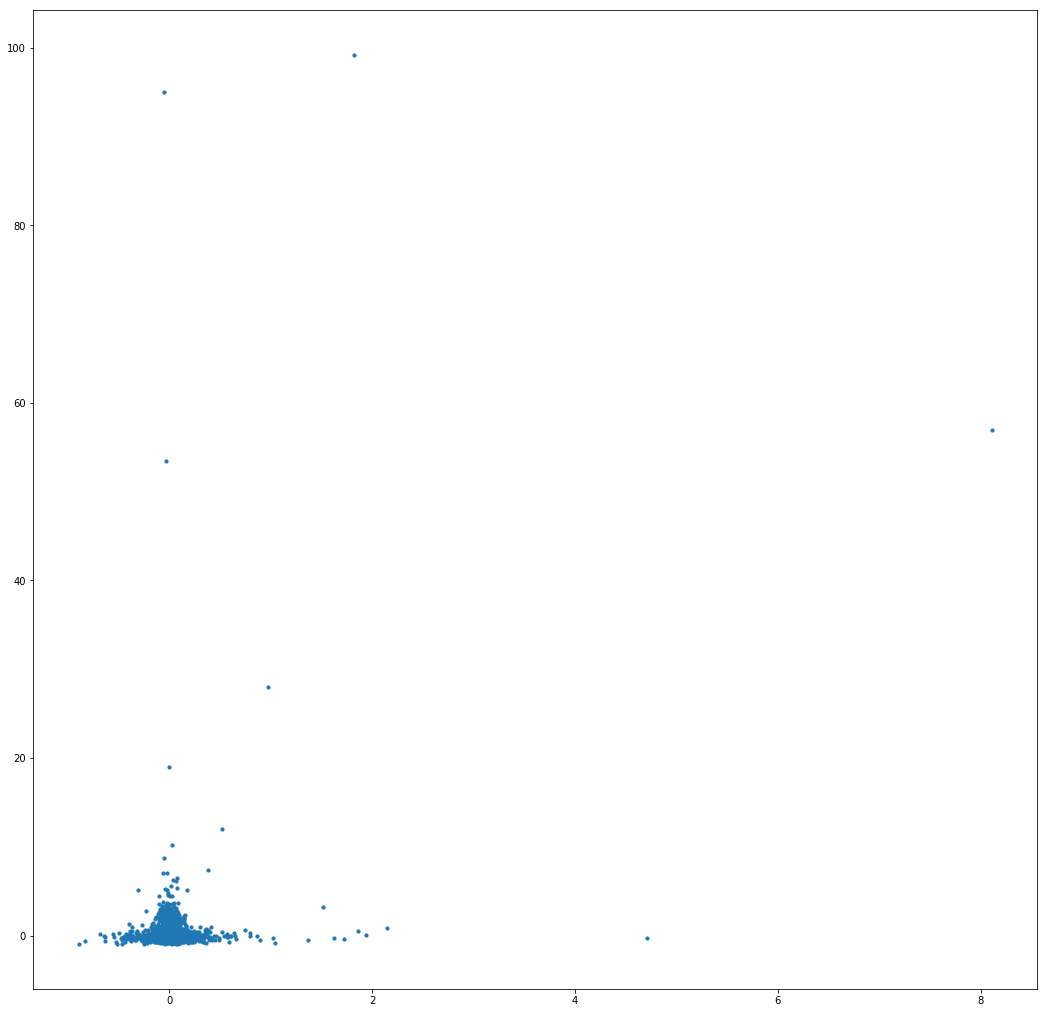

In [75]:
plt.figure(figsize=(2^16, 2^16))
a = file_final[['SPEED_MEAN', 'NUM_VEHICLES']].pct_change()
plt.scatter(a.SPEED_MEAN, a.NUM_VEHICLES, s = 10)
a.SPEED_MEAN.corr(a.NUM_VEHICLES)

In [76]:
b = file_final['SPEED_MEAN'].pct_change()
b.autocorr()

-0.1379092878502425